In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

def data_multimodal(n_samples=400, noise_std=0.5, random_state=42):
    # Generate input features
    np.random.seed(random_state)
    X = np.random.uniform(-1.5, 1.5, (n_samples, 5))
    
    # Create a bimodal function by combining two different regimes
    # Based on a threshold condition to create clear separation
    condition = X[:, 0] > 0.5  # Split based on first feature
    
    # Regime 1: For X[:, 0] <= 0
    f1 = -1 + 2 * np.sin(2 * X[:, 0]) + 0.5 * X[:, 1]**2
    
    # Regime 2: For X[:, 0] > 0  
    f2 = 2 + X[:, 0]**2 + 0.3 * X[:, 2] * X[:, 3]
    
    # Combine the two regimes
    true_f = np.where(condition, f2, f1)
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, n_samples)
    y = true_f + noise

    return X, y

X, y = data_multimodal()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

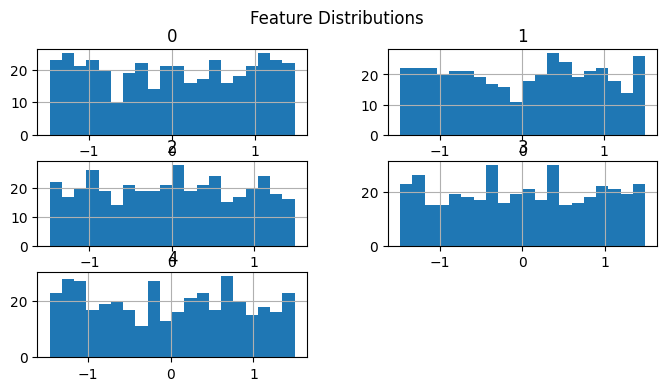

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(8, 4), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

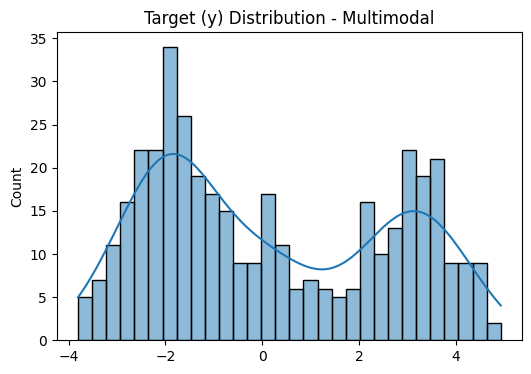

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True, bins=30)
plt.title("Target (y) Distribution - Multimodal")
plt.show()

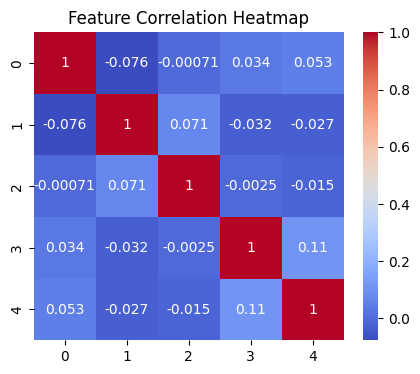

In [7]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
import benchmarks.mtmh.matrix.comparison as comparison

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=2, n_chains=4, ndpost=1000, nskip=100, n_trees=100)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.194720                 1.252719             1.208327   
1                  1.136176                 1.239898             1.160678   
mean               1.165448                 1.246308             1.184503   
std                0.041397                 0.009066             0.033693   

      DefaultBART_Rhat_RMSE  
0                  1.347306  
1                  1.399156  
mean               1.373231  
std                0.036664  


In [9]:
import benchmarks.mtmh.matrix.comparison as comparison

mse_results = comparison.bart_mse_comparison(X, y, n_runs=2, n_skip=100, n_post=100, n_trees=100)
print("MSE/Interval/Time comparison results:")
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")

INFO:2025-09-15 13:29:33,377:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


MSE/Interval/Time comparison results:
test_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      0.417981  0.375573  0.310927  0.299085  0.321395  0.315630
1      0.429142  0.340948  0.326057  0.313850  0.291274  0.323530
mean   0.423561  0.358261  0.318492  0.306468  0.306335  0.319580
std    0.007892  0.024484  0.010698  0.010440  0.021299  0.005586

train_mse:
      bart_mtmh      bart       btz       sto        rf           xgb
0      0.037368  0.142452  0.114043  0.181023  0.047392  3.154083e-06
1      0.051895  0.150660  0.145663  0.166501  0.049546  3.133884e-06
mean   0.044632  0.146556  0.129853  0.173762  0.048469  3.143983e-06
std    0.010273  0.005804  0.022358  0.010268  0.001523  1.428248e-08

pi_length:
      bart_mtmh      bart       btz       sto
0      1.978806  2.103050  2.339962  1.635954
1      2.283946  2.095345  2.265232  1.524864
mean   2.131376  2.099197  2.302597  1.580409
std    0.215767  0.005448  0.052842  0.078553

coverage:
      b